In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
from tqdm import tqdm
from seaborn import set_style
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.api import SARIMAX
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import xgboost as xgb

set_style("whitegrid")
#Import the csv file
dfhl=pd.read_csv('data/dfhl.csv', parse_dates=['time'])
dfhl=dfhl.astype({'open':'float','volume':'float','MACD':'float','MACD_Hist':'float',
                  'MACD_Signal':'float','high':'float','low':'float'})
dfhl

,time,open,volume,MACD,MACD_Hist,MACD_Signal,high,low
0,2023-05-31 15:59:00,418.105,5653492.0,-0.1139,-0.0884,-0.0254,418.105,417.76
1,2023-05-31 15:58:00,417.760,3337166.0,-0.1199,-0.1165,-0.0033,418.105,417.76
2,2023-05-31 15:57:00,417.795,2345699.0,-0.0906,-0.1164,0.0258,418.105,417.76
3,2023-05-31 15:56:00,417.885,1656396.0,-0.0556,-0.1105,0.0549,418.105,417.76
4,2023-05-31 15:55:00,417.970,2261461.0,-0.0192,-0.1018,0.0825,418.105,417.76
...,...,...,...,...,...,...,...,...
8965,2023-04-28 09:34:00,411.980,222984.0,0.1197,0.0466,0.0732,414.750,411.98
8966,2023-04-28 09:33:00,412.140,188445.0,0.1086,0.0471,0.0615,414.750,411.95
8967,2023-04-28 09:32:00,411.950,282485.0,0.0766,0.0269,0.0497,414.750,411.90
8968,2023-04-28 09:31:00,411.900,306992.0,0.0540,0.0109,0.0430,414.695,411.49


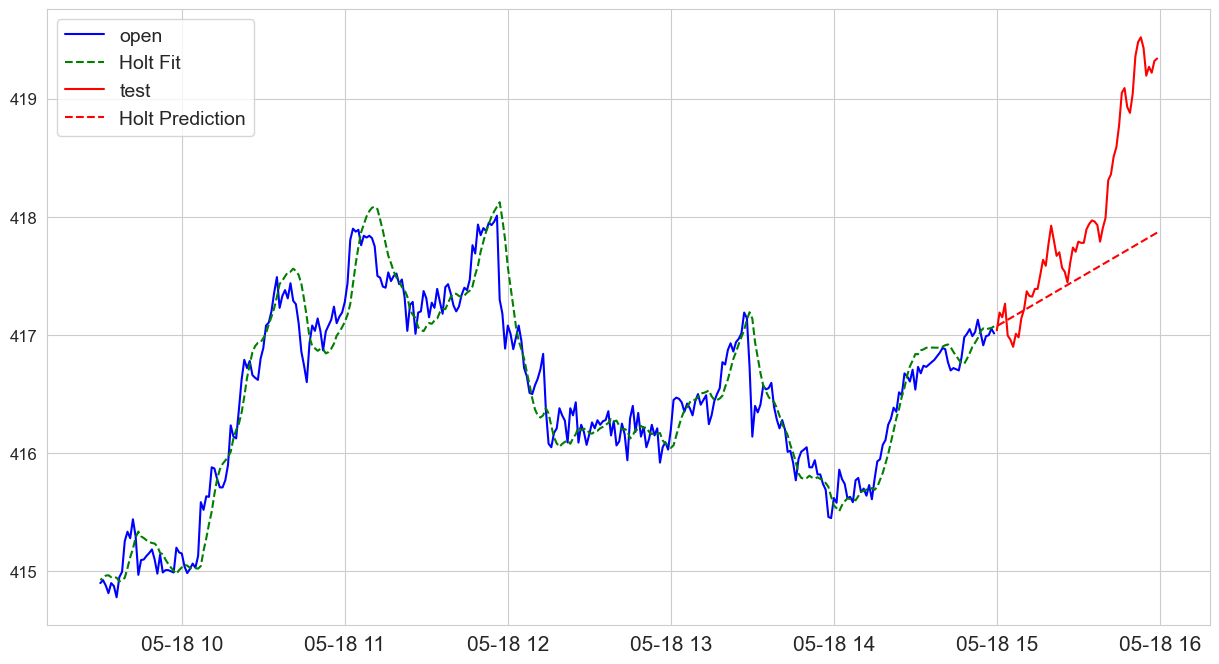

In [4]:
#Try Holt prediction for the last hour on 5/18 with trainning set from 9:30 am to 3 pm. Choose sample parameters.

exp_smooth=Holt(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & 
                         (dfhl.time<pd.Timestamp(2023,5,18,15))].open.to_list()[::-1]).fit(smoothing_level=0.2,
                                                                                           smoothing_trend=0.2,
                                                                                           optimized=False)
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].time,
         np.flip(exp_smooth.fittedvalues),'g--',label='Holt Fit')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,15)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,15)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'r',label='test')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,15)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         np.flip(exp_smooth.forecast(60)),'r--',label='Holt Prediction')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [5]:
#With the 2-hours windows idea, conduct a grid search for alpha and beta (8mins).

train_series=dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].open
train_values=train_series.to_list()[::-1]
holt_predict_high=np.zeros((20,20,211));holt_predict_low=np.zeros((20,20,211))
holt_mae_high=np.zeros((20,20));holt_mae_low=np.zeros((20,20))
for j in tqdm(range(20), desc="j"):
    for k in tqdm(range(20), desc="k"):
        for i in range(211):
            holt_smooth=Holt(train_values[i:i+120]).fit(smoothing_level=0.01*(j+1),
                                        smoothing_trend=0.01*(k+1),
                                        optimized=False)
            holt_predict_high[j,k,i]=holt_smooth.forecast(60).max();holt_predict_low[j,k,i]=holt_smooth.forecast(60).min()
        holt_mae_high[j,k] = mean_absolute_error(holt_predict_high[j,k], dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) &
                                                      (dfhl.time<=pd.Timestamp(2023,5,18,15))].high.to_list()[::-1])
        holt_mae_low[j,k] = mean_absolute_error(holt_predict_low[j,k], dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) &
                                                      (dfhl.time<=pd.Timestamp(2023,5,18,15))].low.to_list()[::-1])

holthighindex=np.unravel_index(np.argmin(holt_mae_high),(20,20))
holtlowindex=np.unravel_index(np.argmin(holt_mae_low),(20,20))
print(holthighindex);print(holtlowindex)

k: 100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.27it/s]


k: 100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.28it/s]


k: 100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


j: 100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [05:13<00:00, 15.68s/it]

(19, 3)
(19, 1)


In [6]:
#Hiothighindex and holtlowindex are (19,3) and (19,1)
print("For high value, alpha=",0.01*(holthighindex[0]+1),"and beta=",0.01*(holthighindex[1]+1))
print("For low value, alpha=",0.01*(holtlowindex[0]+1),"and beta=",0.01*(holtlowindex[1]+1))
print('MAE_HIGH:',holt_mae_high[holthighindex[0],holthighindex[1]])
print('MAE_LOW:',holt_mae_low[holtlowindex[0],holtlowindex[1]])

For high value, alpha= 0.2 and beta= 0.04
For low value, alpha= 0.2 and beta= 0.02
MAE_HIGH: 0.8311026483410098
MAE_LOW: 0.7582792519573334


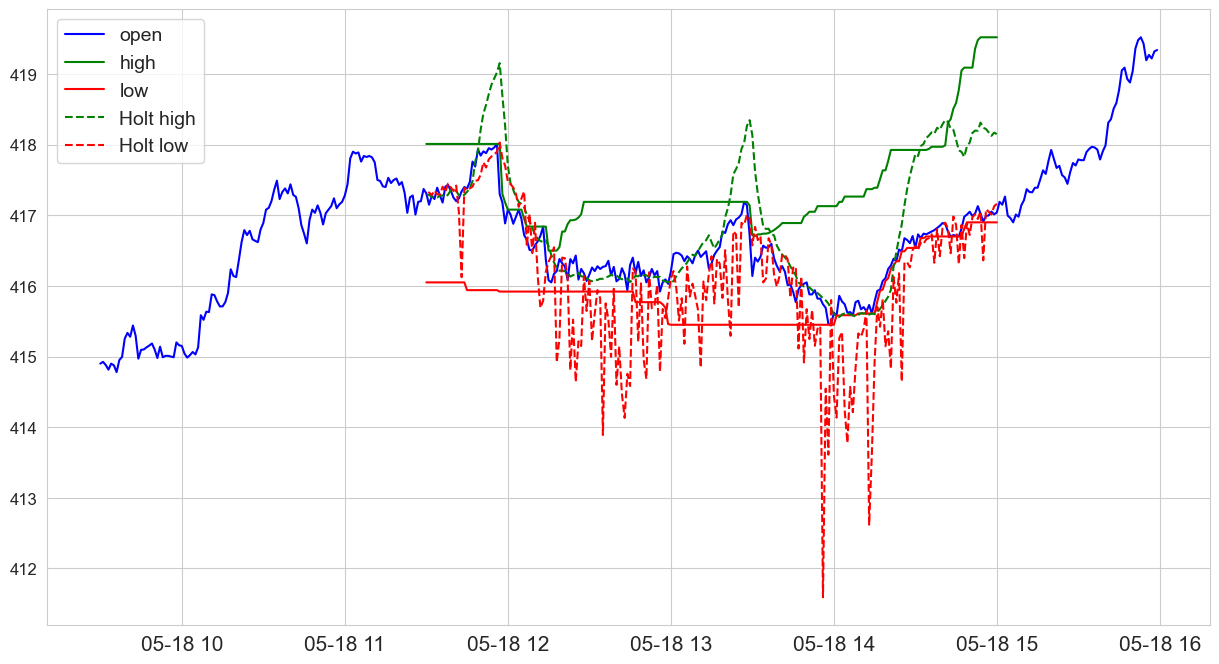

In [7]:
#Draw Holt predictions for high/low 
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         holt_predict_high[19,3][::-1],'g--',label='Holt high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         holt_predict_low[19,1][::-1],'r--',label='Holt low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

<Figure size 1500x800 with 0 Axes>

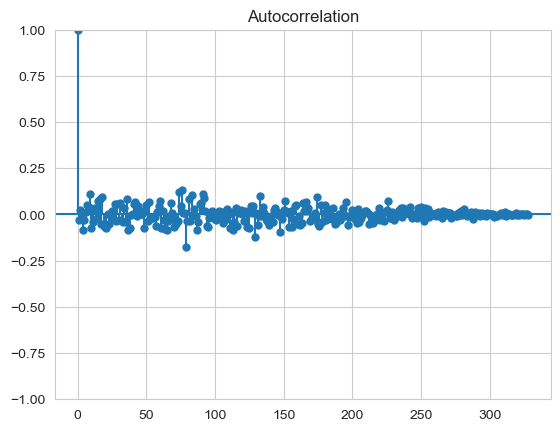

In [8]:
#Try ARIMA (SARIMAX) model. Choose d=1

train_series=dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,18,15))].open
train_values=train_series.to_list()[::-1]
plt.figure(figsize=(15,8))
sm.graphics.tsa.plot_acf(train_series.diff().values[1:],alpha=None,lags=328)
plt.show()


In [9]:
#Conduct a grid search for p and q (14mins).
arima_predict_high=np.zeros((4,4,211))
arima_predict_low=np.zeros((4,4,211))
arima_mae_high=np.zeros((4,4))
arima_mae_low=np.zeros((4,4))

for j in tqdm(range(4),desc='j'):
    for k in tqdm(range(4),desc='k'):
        for i in tqdm(range(211),desc='i'):
            arima=SARIMAX(train_values[i:i+120],order=(j,1,k)).fit(maxiter=500)
            arima_predict_high[j,k,i]=arima.forecast(60).max();arima_predict_low[j,k,i]=arima.forecast(60).min()
        arima_mae_high[j,k] = mean_absolute_error(arima_predict_high[j,k], dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) &
                                                      (dfhl.time<=pd.Timestamp(2023,5,18,15))].high.to_list()[::-1])
        arima_mae_low[j,k] = mean_absolute_error(arima_predict_low[j,k], dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) &
                                                      (dfhl.time<=pd.Timestamp(2023,5,18,15))].low.to_list()[::-1])

arimahighindex=np.unravel_index(np.argmin(arima_mae_high),(4,4))
arimalowindex=np.unravel_index(np.argmin(arima_mae_low),(4,4))
print(arimahighindex);print(arimalowindex)

k:   0%|                                                                                         | 0/4 [00:00<?, ?it/s]

i:   0%|                                                                                       | 0/211 [00:00<?, ?it/s]

i:   1%|█                                                                              | 3/211 [00:00<00:08, 24.67it/s]C:\Users\sailu\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


i:   4%|███▎                                                                           | 9/211 [00:00<00:04, 42.60it/s]

i:   8%|██████▎                                                                       | 17/211 [00:00<00:03, 55.18it/s]

i:  11%|████████▊                                                                     | 24/211 [00:00<00:03, 60.00it/s]C:\Users\sailu\anaconda3\lib\site-packages\statsmod

i:  45%|███████████████████████████████████▍                                          | 96/211 [00:03<00:04, 26.12it/s]

i:  47%|████████████████████████████████████▌                                         | 99/211 [00:03<00:04, 25.25it/s]

i:  48%|█████████████████████████████████████▏                                       | 102/211 [00:04<00:04, 25.56it/s]

i:  50%|██████████████████████████████████████▎                                      | 105/211 [00:04<00:04, 26.30it/s]

i:  51%|███████████████████████████████████████▍                                     | 108/211 [00:04<00:03, 27.08it/s]

i:  53%|████████████████████████████████████████▊                                    | 112/211 [00:04<00:03, 27.79it/s]

i:  55%|██████████████████████████████████████████▎                                  | 116/211 [00:04<00:03, 30.40it/s]

i:  57%|███████████████████████████████████████████▊                                 | 120/211 [00:04<00:03, 30.16it/s]

i:  59%|████████████████████████

i:  25%|███████████████████▌                                                          | 53/211 [00:01<00:03, 48.86it/s]

i:  27%|█████████████████████▍                                                        | 58/211 [00:01<00:03, 48.20it/s]

i:  30%|███████████████████████▎                                                      | 63/211 [00:01<00:03, 48.09it/s]

i:  32%|█████████████████████████▏                                                    | 68/211 [00:01<00:02, 48.02it/s]

i:  35%|██████████████████████████▉                                                   | 73/211 [00:01<00:02, 46.49it/s]

i:  37%|████████████████████████████▊                                                 | 78/211 [00:01<00:02, 45.86it/s]

i:  40%|███████████████████████████████                                               | 84/211 [00:01<00:02, 47.95it/s]

i:  42%|████████████████████████████████▉                                             | 89/211 [00:01<00:02, 45.82it/s]

i:  45%|████████████████████████

k:  50%|████████████████████████████████████████▌                                        | 2/4 [00:16<00:18,  9.18s/it]

i:   0%|                                                                                       | 0/211 [00:00<?, ?it/s]

i:   1%|▋                                                                              | 2/211 [00:00<00:14, 14.86it/s]

i:   2%|█▍                                                                             | 4/211 [00:00<00:15, 13.30it/s]

i:   3%|██▏                                                                            | 6/211 [00:00<00:14, 13.75it/s]

i:   4%|██▉                                                                            | 8/211 [00:00<00:15, 12.92it/s]

i:   5%|███▋                                                                          | 10/211 [00:00<00:15, 12.74it/s]

i:   6%|████▍                                                                         | 12/211 [00:00<00:15, 12.57it/s]

i:   7%|█████▏                  

i:   7%|█████▌                                                                        | 15/211 [00:01<00:20,  9.34it/s]

i:   8%|█████▉                                                                        | 16/211 [00:01<00:20,  9.46it/s]

i:   8%|██████▎                                                                       | 17/211 [00:01<00:21,  9.14it/s]

i:   9%|██████▋                                                                       | 18/211 [00:01<00:21,  9.09it/s]

i:   9%|███████                                                                       | 19/211 [00:02<00:22,  8.55it/s]

i:   9%|███████▍                                                                      | 20/211 [00:02<00:23,  8.08it/s]

i:  10%|███████▊                                                                      | 21/211 [00:02<00:23,  8.19it/s]

i:  10%|████████▏                                                                     | 22/211 [00:02<00:23,  8.06it/s]

i:  11%|████████▌               

i:  98%|███████████████████████████████████████████████████████████████████████████▌ | 207/211 [00:21<00:00,  8.54it/s]

i:  99%|███████████████████████████████████████████████████████████████████████████▉ | 208/211 [00:21<00:00,  8.65it/s]

i:  99%|████████████████████████████████████████████████████████████████████████████▎| 209/211 [00:21<00:00,  8.67it/s]

i: 100%|█████████████████████████████████████████████████████████████████████████████| 211/211 [00:21<00:00,  9.67it/s]

k:   0%|                                                                                         | 0/4 [00:00<?, ?it/s]

i:   0%|                                                                                       | 0/211 [00:00<?, ?it/s]

i:   2%|█▍                                                                             | 4/211 [00:00<00:05, 35.52it/s]

i:   4%|██▉                                                                            | 8/211 [00:00<00:05, 35.19it/s]

i:   6%|████▊                   

i:  64%|█████████████████████████████████████████████████▋                           | 136/211 [00:10<00:06, 11.02it/s]

i:  65%|██████████████████████████████████████████████████▎                          | 138/211 [00:11<00:06, 10.55it/s]

i:  66%|███████████████████████████████████████████████████                          | 140/211 [00:11<00:06, 11.20it/s]

i:  67%|███████████████████████████████████████████████████▊                         | 142/211 [00:11<00:06, 11.44it/s]

i:  68%|████████████████████████████████████████████████████▌                        | 144/211 [00:11<00:05, 11.21it/s]

i:  69%|█████████████████████████████████████████████████████▎                       | 146/211 [00:11<00:06, 10.76it/s]

i:  70%|██████████████████████████████████████████████████████                       | 148/211 [00:12<00:05, 11.47it/s]

i:  71%|██████████████████████████████████████████████████████▋                      | 150/211 [00:12<00:05, 11.74it/s]

i:  72%|████████████████████████

i:  42%|████████████████████████████████▌                                             | 88/211 [00:16<00:16,  7.59it/s]

i:  42%|████████████████████████████████▉                                             | 89/211 [00:16<00:16,  7.52it/s]

i:  43%|█████████████████████████████████▋                                            | 91/211 [00:16<00:12,  9.26it/s]

i:  44%|██████████████████████████████████▍                                           | 93/211 [00:16<00:14,  8.08it/s]

i:  45%|██████████████████████████████████▋                                           | 94/211 [00:17<00:15,  7.37it/s]

i:  45%|███████████████████████████████████                                           | 95/211 [00:17<00:16,  6.91it/s]

i:  45%|███████████████████████████████████▍                                          | 96/211 [00:17<00:15,  7.21it/s]

i:  46%|███████████████████████████████████▊                                          | 97/211 [00:17<00:17,  6.65it/s]

i:  46%|████████████████████████

i:   7%|█████▌                                                                        | 15/211 [00:03<00:36,  5.33it/s]

i:   8%|█████▉                                                                        | 16/211 [00:03<00:40,  4.85it/s]

i:   8%|██████▎                                                                       | 17/211 [00:03<00:42,  4.55it/s]

i:   9%|██████▋                                                                       | 18/211 [00:03<00:42,  4.50it/s]

i:   9%|███████                                                                       | 19/211 [00:04<00:42,  4.49it/s]

i:   9%|███████▍                                                                      | 20/211 [00:04<00:40,  4.73it/s]

i:  10%|███████▊                                                                      | 21/211 [00:04<00:38,  4.93it/s]

i:  10%|████████▏                                                                     | 22/211 [00:04<00:35,  5.34it/s]

i:  11%|████████▌               

i:  69%|█████████████████████████████████████████████████████▎                       | 146/211 [00:34<00:19,  3.34it/s]

i:  70%|█████████████████████████████████████████████████████▋                       | 147/211 [00:34<00:18,  3.49it/s]

i:  71%|██████████████████████████████████████████████████████▎                      | 149/211 [00:34<00:11,  5.31it/s]

i:  71%|██████████████████████████████████████████████████████▋                      | 150/211 [00:34<00:13,  4.63it/s]

i:  72%|███████████████████████████████████████████████████████                      | 151/211 [00:35<00:14,  4.28it/s]

i:  72%|███████████████████████████████████████████████████████▍                     | 152/211 [00:35<00:15,  3.77it/s]

i:  73%|███████████████████████████████████████████████████████▊                     | 153/211 [00:35<00:15,  3.74it/s]

i:  73%|████████████████████████████████████████████████████████▏                    | 154/211 [00:36<00:17,  3.28it/s]

i:  73%|████████████████████████

i:  82%|██████████████████████████████████████████████████████████████▊              | 172/211 [00:07<00:01, 25.61it/s]

i:  83%|███████████████████████████████████████████████████████████████▊             | 175/211 [00:07<00:01, 24.13it/s]

i:  84%|████████████████████████████████████████████████████████████████▉            | 178/211 [00:07<00:01, 21.81it/s]

i:  86%|██████████████████████████████████████████████████████████████████           | 181/211 [00:07<00:01, 23.49it/s]

i:  87%|███████████████████████████████████████████████████████████████████▏         | 184/211 [00:07<00:01, 24.29it/s]

i:  89%|████████████████████████████████████████████████████████████████████▌        | 188/211 [00:07<00:00, 25.73it/s]

i:  91%|█████████████████████████████████████████████████████████████████████▋       | 191/211 [00:07<00:00, 26.04it/s]

i:  92%|██████████████████████████████████████████████████████████████████████▊      | 194/211 [00:08<00:00, 23.40it/s]

i:  93%|████████████████████████

i:  93%|███████████████████████████████████████████████████████████████████████▉     | 197/211 [00:18<00:01,  8.79it/s]

i:  94%|████████████████████████████████████████████████████████████████████████▌    | 199/211 [00:18<00:01, 10.39it/s]

i:  95%|█████████████████████████████████████████████████████████████████████████▎   | 201/211 [00:18<00:00, 10.11it/s]

i:  96%|██████████████████████████████████████████████████████████████████████████   | 203/211 [00:19<00:00,  8.93it/s]

i:  97%|██████████████████████████████████████████████████████████████████████████▍  | 204/211 [00:19<00:00,  8.82it/s]

i:  98%|███████████████████████████████████████████████████████████████████████████▏ | 206/211 [00:19<00:00,  8.88it/s]

i:  99%|███████████████████████████████████████████████████████████████████████████▉ | 208/211 [00:19<00:00,  9.33it/s]

i:  99%|████████████████████████████████████████████████████████████████████████████▎| 209/211 [00:19<00:00,  8.84it/s]

i: 100%|████████████████████████

i:  56%|███████████████████████████████████████████                                  | 118/211 [00:26<00:25,  3.72it/s]

i:  56%|███████████████████████████████████████████▍                                 | 119/211 [00:26<00:24,  3.72it/s]

i:  57%|███████████████████████████████████████████▊                                 | 120/211 [00:26<00:25,  3.57it/s]

i:  57%|████████████████████████████████████████████▏                                | 121/211 [00:27<00:25,  3.59it/s]

i:  58%|████████████████████████████████████████████▌                                | 122/211 [00:27<00:23,  3.79it/s]

i:  58%|████████████████████████████████████████████▉                                | 123/211 [00:27<00:20,  4.29it/s]

i:  59%|█████████████████████████████████████████████▌                               | 125/211 [00:27<00:14,  5.78it/s]

i:  60%|█████████████████████████████████████████████▉                               | 126/211 [00:28<00:16,  5.26it/s]

i:  60%|████████████████████████

i:  17%|████████████▉                                                                 | 35/211 [00:18<01:44,  1.69it/s]

i:  17%|█████████████▎                                                                | 36/211 [00:19<01:54,  1.53it/s]

i:  18%|█████████████▋                                                                | 37/211 [00:19<02:00,  1.44it/s]

i:  18%|██████████████                                                                | 38/211 [00:20<01:45,  1.63it/s]

i:  18%|██████████████▍                                                               | 39/211 [00:20<01:28,  1.93it/s]

i:  19%|██████████████▊                                                               | 40/211 [00:21<01:29,  1.92it/s]

i:  19%|███████████████▏                                                              | 41/211 [00:21<01:34,  1.80it/s]

i:  20%|███████████████▌                                                              | 42/211 [00:22<01:16,  2.20it/s]

i:  20%|███████████████▉        

i:  76%|██████████████████████████████████████████████████████████▊                  | 161/211 [01:18<00:26,  1.86it/s]

i:  77%|███████████████████████████████████████████████████████████                  | 162/211 [01:19<00:27,  1.77it/s]

i:  77%|███████████████████████████████████████████████████████████▍                 | 163/211 [01:20<00:26,  1.84it/s]

i:  78%|███████████████████████████████████████████████████████████▊                 | 164/211 [01:20<00:24,  1.89it/s]

i:  78%|████████████████████████████████████████████████████████████▏                | 165/211 [01:21<00:27,  1.65it/s]

i:  79%|████████████████████████████████████████████████████████████▌                | 166/211 [01:22<00:28,  1.59it/s]

i:  79%|████████████████████████████████████████████████████████████▉                | 167/211 [01:22<00:25,  1.73it/s]

i:  80%|█████████████████████████████████████████████████████████████▎               | 168/211 [01:22<00:22,  1.87it/s]

i:  80%|████████████████████████

(3, 3)
(2, 3)


In [10]:
#arimahighindex and arimalowindex are (3,3) and (2,3)
print("For high value, p=",arimahighindex[0],"and q=",arimahighindex[1])
print("For low value, p=",arimalowindex[0],"and q=",arimalowindex[1])
print('MAE_HIGH:',arima_mae_high[arimahighindex[0],arimahighindex[1]])
print('MAE_LOW:',arima_mae_low[arimalowindex[0],arimalowindex[1]])

For high value, p= 3 and q= 3
For low value, p= 2 and q= 3
MAE_HIGH: 0.8849430022343845
MAE_LOW: 0.5939643606768579


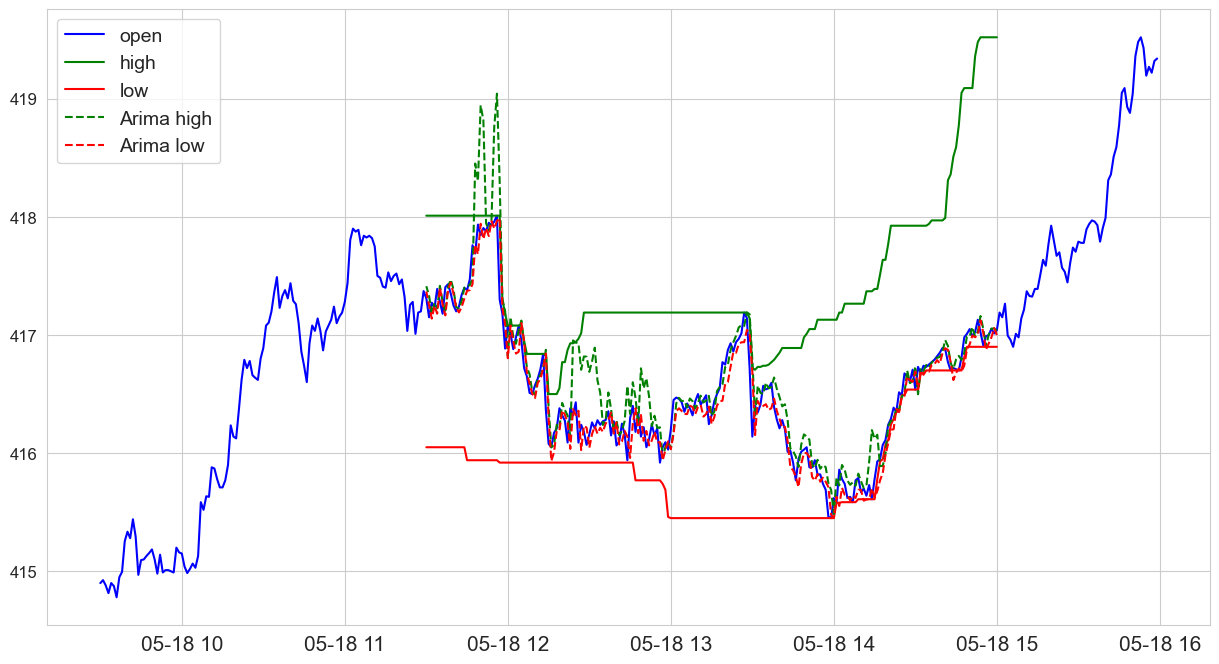

In [11]:
#Draw Arima predictions for high/low
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         arima_predict_high[3,3][::-1],'g--',label='Arima high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         arima_predict_low[2,3][::-1],'r--',label='Arima low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [3]:
#Use Linear Regression.

X_train=pd.read_csv('data/X_train.csv').astype(float)
Y_train=pd.read_csv('data/Y_train.csv').astype(float)
X_test=pd.read_csv('data/X_test.csv').astype(float)
Y_test=pd.read_csv('data/Y_test.csv').astype(float)


linearh=LinearRegression().fit(X_train,Y_train['High'])
linearl=LinearRegression().fit(X_train,Y_train['Low'])
linear_mae_high=mean_absolute_error(linearh.predict(X_test),Y_test['High'])
linear_mae_low=mean_absolute_error(linearl.predict(X_test),Y_test['Low'])

print('MAE_HIGH:',linear_mae_high)
print('MAE_LOW:',linear_mae_low)


MAE_HIGH: 0.671407446424765
MAE_LOW: 0.4760532839809675


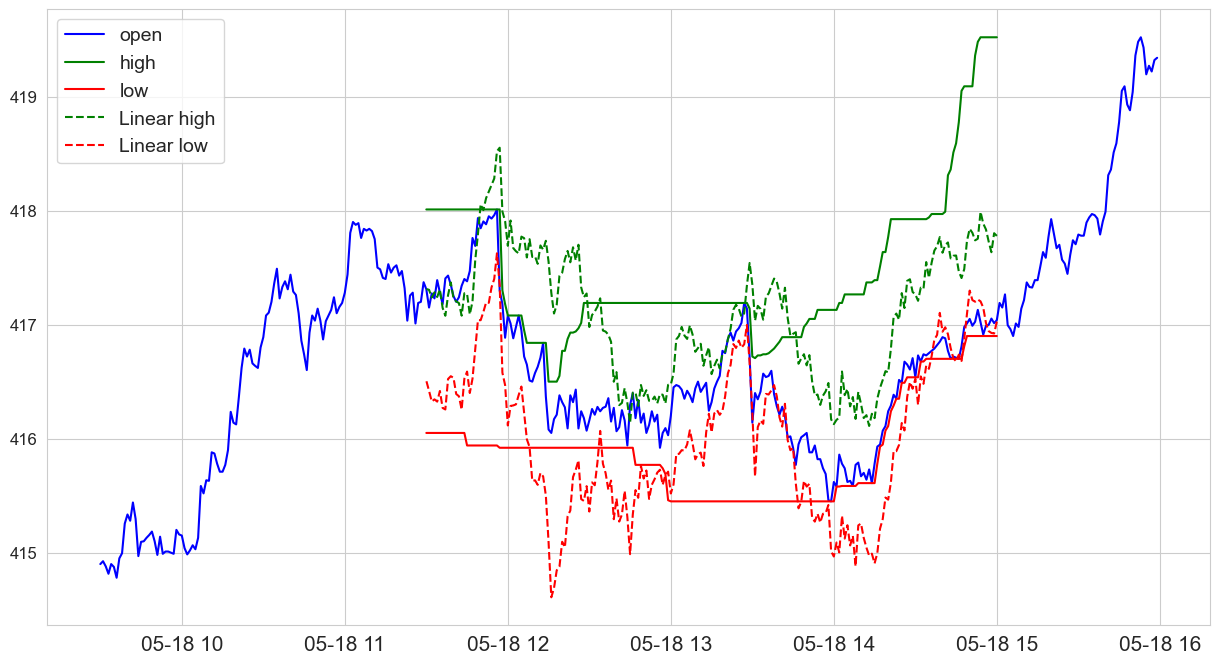

In [4]:
#Draw LinearRegression predictions for high/low

plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(linearh.predict(X_test)),'g--',label='Linear high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(linearl.predict(X_test)),'r--',label='Linear low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [ ]:
#Use Ridge Linear Regression. Conduct a grid search for alpha from 0 to 0.05. (3min)

X_train=pd.read_csv('data/X_train.csv').astype(float)
Y_train=pd.read_csv('data/Y_train.csv').astype(float)
X_test=pd.read_csv('data/X_test.csv').astype(float)
Y_test=pd.read_csv('data/Y_test.csv').astype(float)

ridge_predict_high=np.zeros(500)
ridge_predict_low=np.zeros(500)
ridge_mae_high=np.zeros(500)
ridge_mae_low=np.zeros(500)

for i in tqdm(range(0,500),desc='i'):
    ridgeh=Ridge(alpha=0.0001*(i+1)).fit(X_train,Y_train['High'])
    ridgel=Ridge(alpha=0.0001*(i+1)).fit(X_train,Y_train['Low'])
    ridge_mae_high[i]=mean_absolute_error(ridgeh.predict(X_test),Y_test['High'])
    ridge_mae_low[i]=mean_absolute_error(ridgel.predict(X_test),Y_test['Low'])
ridgehighindex=np.argmin(ridge_mae_high)
ridgelowindex=np.argmin(ridge_mae_low)

print('alpha for high=',0.0001*(ridgehighindex+1))
print('alpha for low=',0.0001*(ridgelowindex+1))

i:   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.24895e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.24895e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
i:   0%|          | 1/500 [00:00<02:00,  4.14it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.49539e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.49539e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True

alpha for high= 0.0198
alpha for low= 0.0


In [ ]:
print('MAE_HIGH:',ridge_mae_high[ridgehighindex]);print('MAE_LOW:',ridge_mae_low[ridgelowindex])

MAE_HIGH: 0.624503535719235
MAE_LOW: 0.5323171335486889


C:\Users\sailu\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.38646e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\sailu\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.00375e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


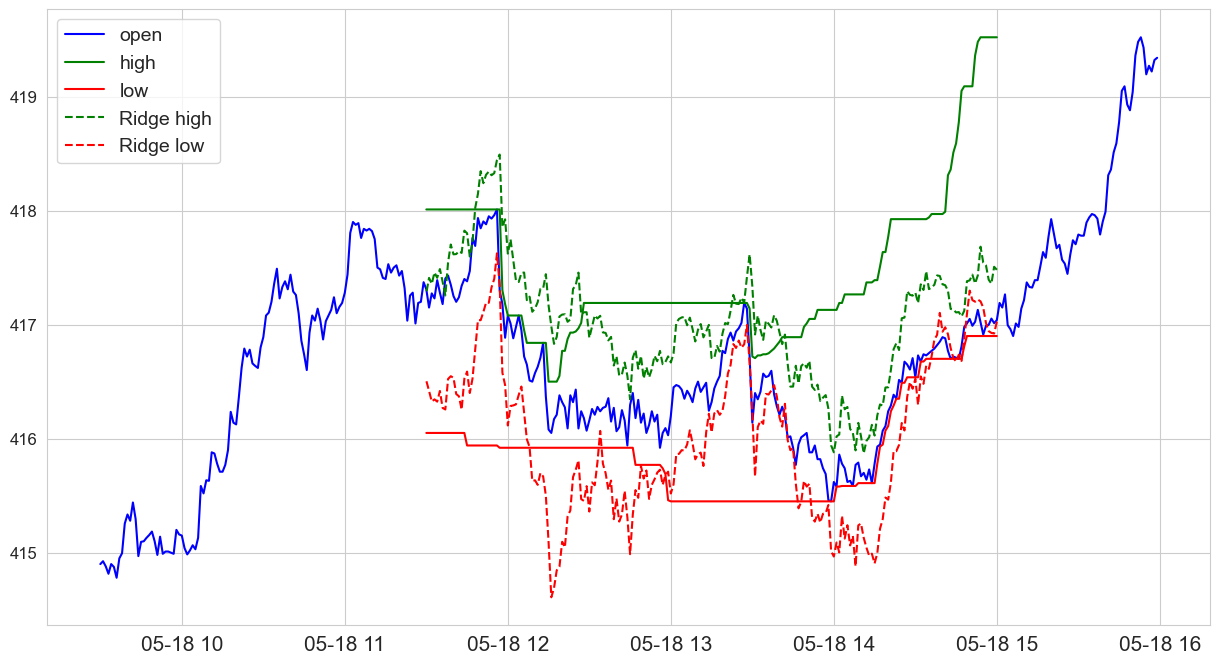

In [5]:
#Draw Ridge predictions for high/low. Alpha for high/low = 0.0199/0.0001 
ridgeh=Ridge(alpha=0.0199).fit(X_train,Y_train['High'])
ridgel=Ridge(alpha=0).fit(X_train,Y_train['Low'])
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(ridgeh.predict(X_test)),'g--',label='Ridge high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(ridgel.predict(X_test)),'r--',label='Ridge low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [ ]:
#Use Lasso Linear Regression. Conduct a grid search for alpha from 0 to 0.2 (>5min).

X_train=pd.read_csv('data/X_train.csv').astype(float)
Y_train=pd.read_csv('data/Y_train.csv').astype(float)
X_test=pd.read_csv('data/X_test.csv').astype(float)
Y_test=pd.read_csv('data/Y_test.csv').astype(float)

lasso_predict_high=np.zeros(50)
lasso_predict_low=np.zeros(50)
lasso_mae_high=np.zeros(50)
lasso_mae_low=np.zeros(50)

for i in tqdm(range(0,50),desc='i'):
    lassoh=Lasso(alpha=0.004*(i+1),max_iter=100000).fit(X_train,Y_train['High'])
    lassol=Lasso(alpha=0.004*(i+1),max_iter=100000).fit(X_train,Y_train['Low'])
    lasso_mae_high[i]=mean_absolute_error(lassoh.predict(X_test),Y_test['High'])
    lasso_mae_low[i]=mean_absolute_error(lassol.predict(X_test),Y_test['Low'])
lassohighindex=np.argmin(lasso_mae_high)
lassolowindex=np.argmin(lasso_mae_low)
print('alpha for high=',0.004*(lassohighindex+1))
print('alpha for low=',0.004*(lassolowindex+1))

i: 100%|██████████| 50/50 [08:41<00:00, 10.44s/it]

alpha for high= 0.004
alpha for low= 0.02


In [ ]:
print('MAE_HIGH:',lasso_mae_high[lassohighindex]);print('MAE_LOW:',lasso_mae_low[lassolowindex])

MAE_HIGH: 0.6329904574169518
MAE_LOW: 0.5220625574284896


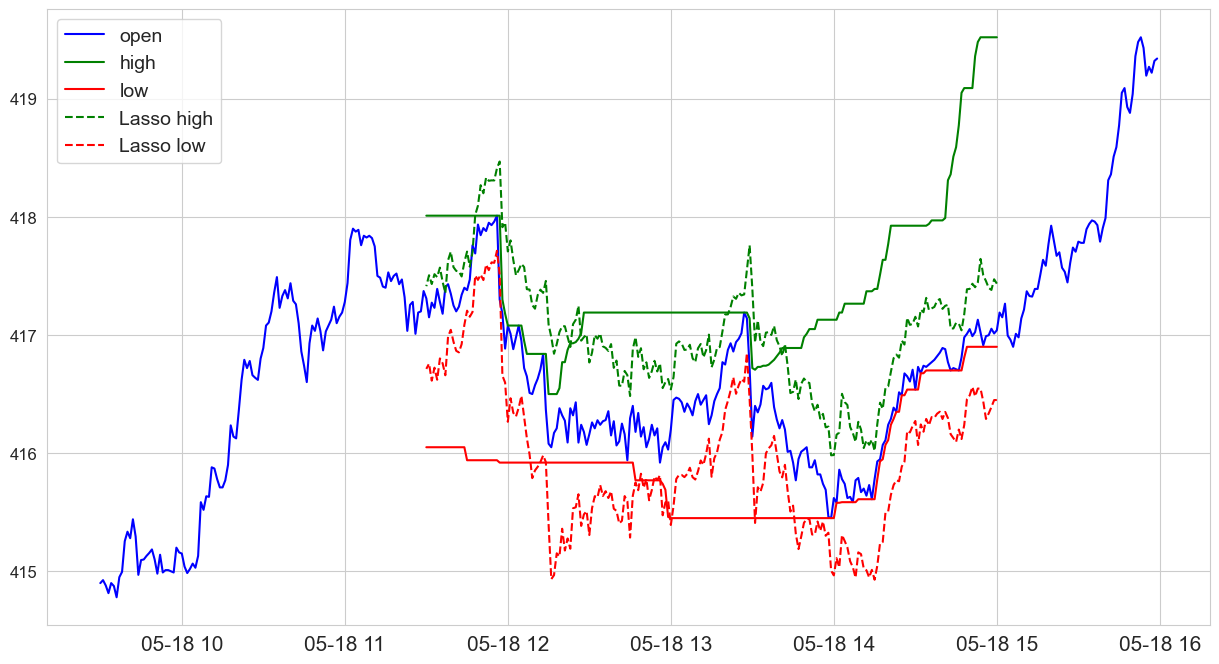

In [6]:
#Draw Lasso predictions for high/low. Alpha for high/low = 0.004/0.02 
lassoh=Lasso(alpha=0.004,max_iter=100000).fit(X_train,Y_train['High'])
lassol=Lasso(alpha=0.02,max_iter=100000).fit(X_train,Y_train['Low'])
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(lassoh.predict(X_test)),'g--',label='Lasso high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(lassol.predict(X_test)),'r--',label='Lasso low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [7]:
#Use DecisionTree and RandomForest (4min)
X_train=pd.read_csv('data/X_train.csv').astype(float)
Y_train=pd.read_csv('data/Y_train.csv').astype(float)
X_test=pd.read_csv('data/X_test.csv').astype(float)
Y_test=pd.read_csv('data/Y_test.csv').astype(float)

treeh=DecisionTreeRegressor().fit(X_train,Y_train['High'])
treel=DecisionTreeRegressor().fit(X_train,Y_train['Low'])
tree_mae_high=mean_absolute_error(treeh.predict(X_test),Y_test['High'])
tree_mae_low=mean_absolute_error(treel.predict(X_test),Y_test['Low'])

rfh=RandomForestRegressor(random_state=1).fit(X_train,Y_train['High'])
rfl=RandomForestRegressor(random_state=1).fit(X_train,Y_train['Low'])
rf_mae_high=mean_absolute_error(rfh.predict(X_test),Y_test['High'])
rf_mae_low=mean_absolute_error(rfl.predict(X_test),Y_test['Low'])

print('TREE_MAE_HIGH:',tree_mae_high)
print('TREE_MAE_LOW:',tree_mae_low)
print('RF_MAE_HIGH:',rf_mae_high)
print('RF_MAE_LOW:',rf_mae_low)

TREE_MAE_HIGH: 0.688801895734592
TREE_MAE_LOW: 0.6474099526065693
RF_MAE_HIGH: 0.6871025781988969
RF_MAE_LOW: 0.49699328909964546


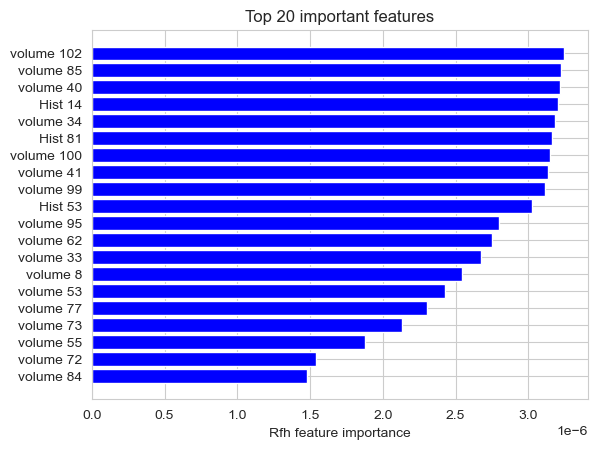

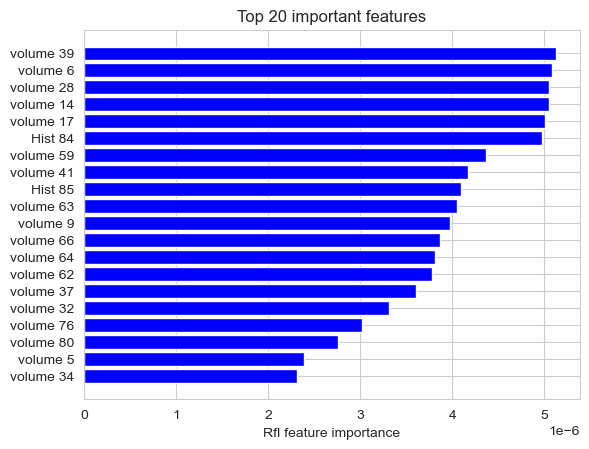

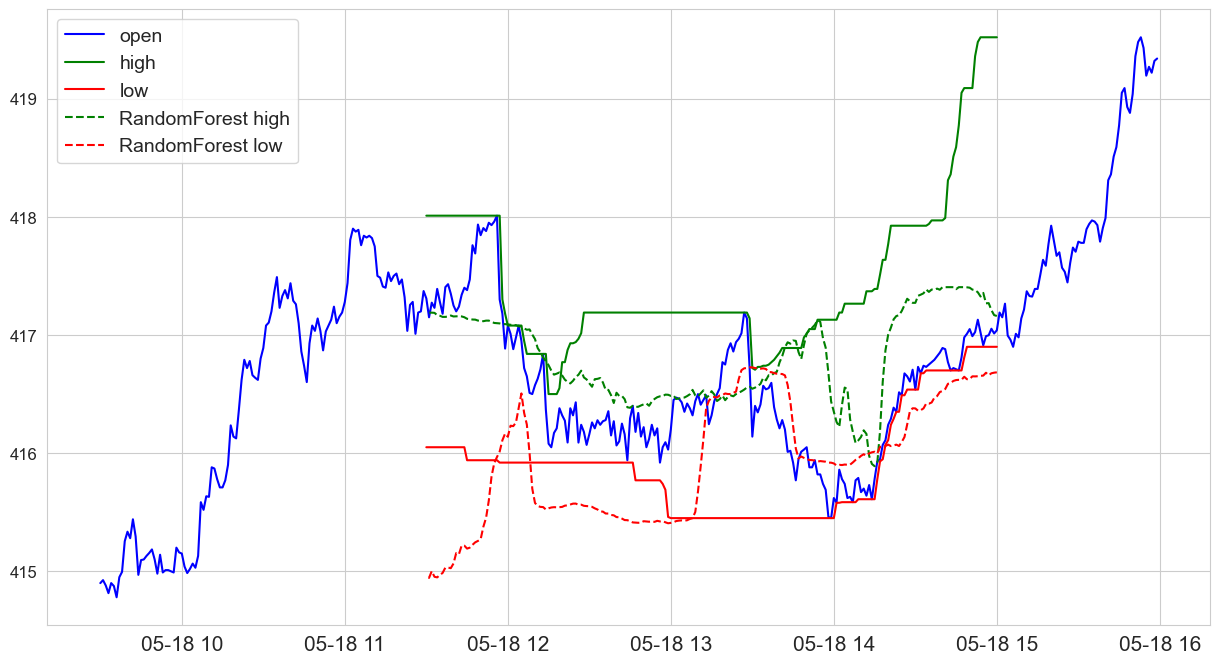

In [8]:
#Draw RandomForest feature importances and predictions for High/Low
indicesh=np.argsort(rfh.feature_importances_)[:20]
plt.barh(range(20), rfh.feature_importances_[indicesh], color='b', align='center')
plt.yticks(range(20), [X_test.columns[i] for i in indicesh])
plt.xlabel('Rfh feature importance')
plt.title('Top 20 important features')
plt.show()

indicesl=np.argsort(rfl.feature_importances_)[:20]
plt.barh(range(20), rfl.feature_importances_[indicesl], color='b', align='center')
plt.yticks(range(20), [X_test.columns[i] for i in indicesl])
plt.xlabel('Rfl feature importance')
plt.title('Top 20 important features')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(rfh.predict(X_test)),'g--',label='RandomForest high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(rfl.predict(X_test)),'r--',label='RandomForest low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [10]:
#Preprocess the data via MinMaxScaler to use SVR
X_train=pd.read_csv('data/X_train.csv').astype(float)
Y_train=pd.read_csv('data/Y_train.csv').astype(float)
X_test=pd.read_csv('data/X_test.csv').astype(float)
Y_test=pd.read_csv('data/Y_test.csv').astype(float)



scaler=MinMaxScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [11]:
#Use SVR model. The parameters are from grid search
svrh=SVR(kernel='rbf', C=5.18, gamma=0.016).fit(X_train_scaled, Y_train['High'])
svr_mae_high=mean_absolute_error(svrh.predict(X_test_scaled),Y_test['High'])

svrl=SVR(kernel='rbf', C=3.76, gamma=0.004).fit(X_train_scaled, Y_train['Low'])
svr_mae_low=mean_absolute_error(svrl.predict(X_test_scaled),Y_test['Low'])

print('MAE_HIGH:',svr_mae_high)
print('MAE_LOW:',svr_mae_low)

MAE_HIGH: 0.6517769877989933
MAE_LOW: 0.4152183805468832


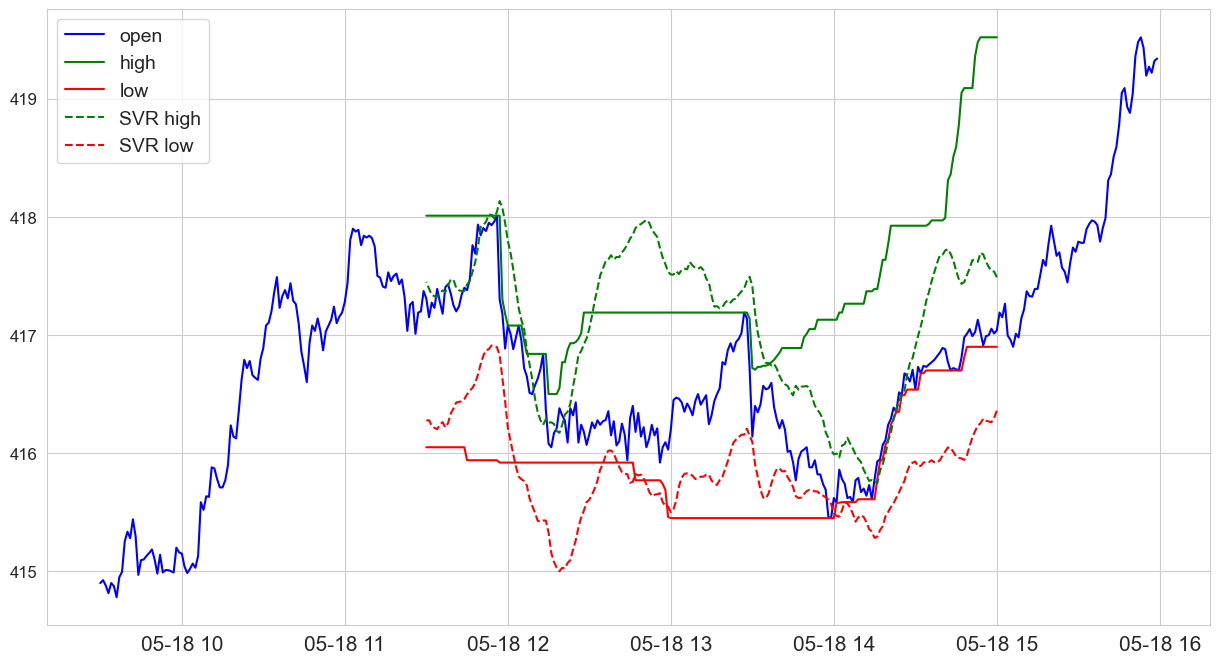

In [12]:
#Draw SVR predictions for High/Low
plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(svrh.predict(X_test_scaled)),'g--',label='SVR high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(svrl.predict(X_test_scaled)),'r--',label='SVR low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

In [13]:
#Use XGBoost. The parameters are from grid search
X_train=pd.read_csv('data/X_train.csv').astype(float)
Y_train=pd.read_csv('data/Y_train.csv').astype(float)
X_test=pd.read_csv('data/X_test.csv').astype(float)
Y_test=pd.read_csv('data/Y_test.csv').astype(float)


xgbh=xgb.XGBRegressor(objective='reg:absoluteerror', max_depth=2, alpha=0.3,
                        min_child_weight=2,seed=1).fit(X_train, Y_train['High'])
xgbl=xgb.XGBRegressor(objective='reg:absoluteerror', max_depth=2, alpha=0,
                        min_child_weight=5,seed=1).fit(X_train, Y_train['Low'])
xgb_mae_high=mean_absolute_error(xgbh.predict(X_test),Y_test['High'])
xgb_mae_low=mean_absolute_error(xgbl.predict(X_test),Y_test['Low'])

print('MAE_HIGH:',xgb_mae_high)
print('MAE_LOW:',xgb_mae_low)





MAE_HIGH: 0.5858999102117873
MAE_LOW: 0.42129327676059264


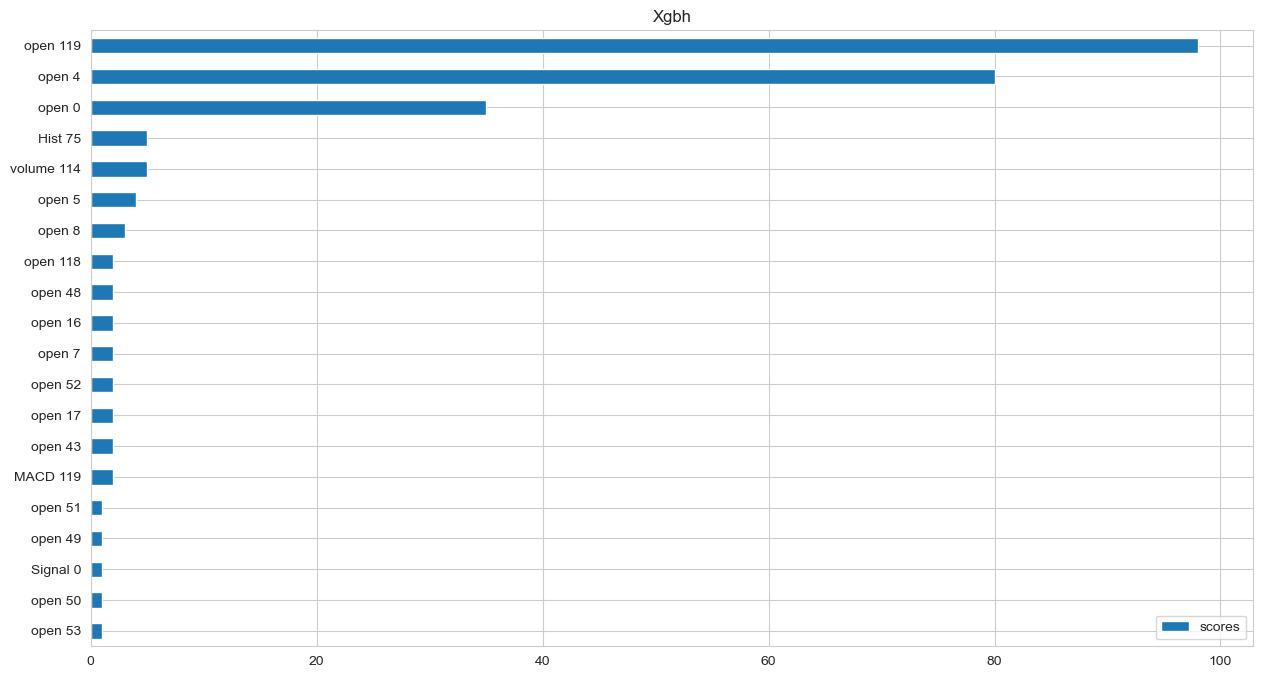

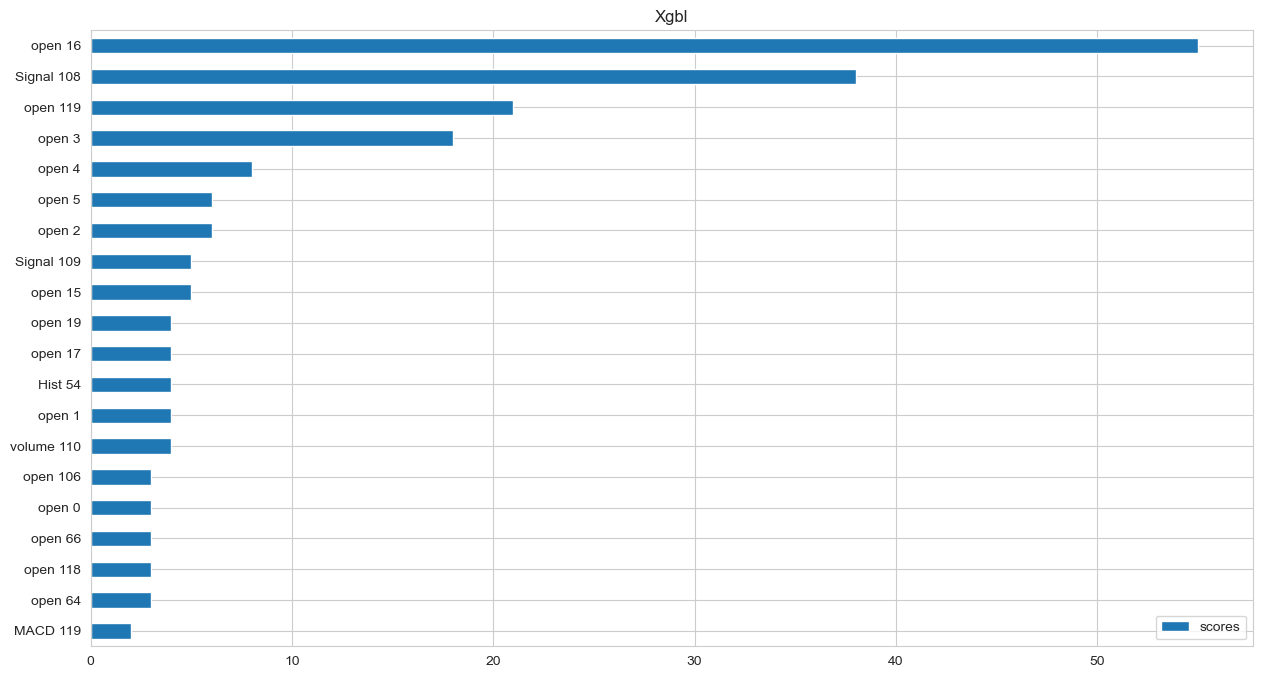

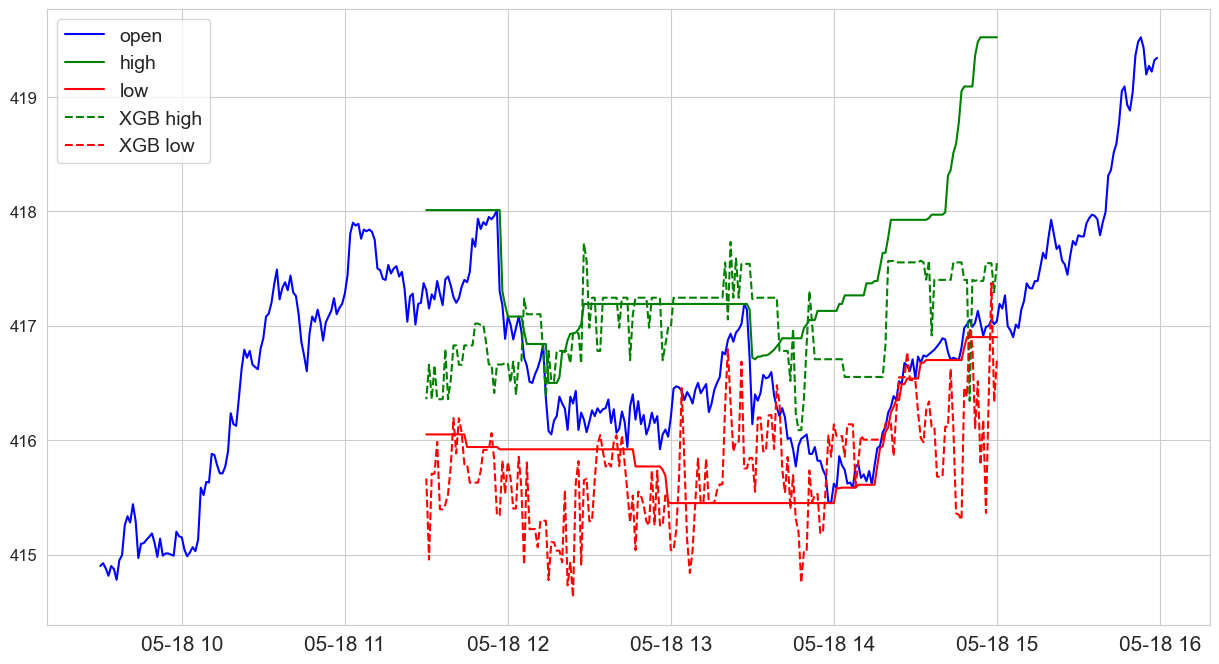

In [14]:
#Draw XGBoost feature importances and predictions for High/Low
feature_scores_h=xgbh.get_booster().get_score(importance_type='weight')
keys_h=list(feature_scores_h.keys())
values_h=list(feature_scores_h.values())

feature_chart_h=pd.DataFrame(data=values_h, index=keys_h, columns=['scores']).sort_values(by='scores')
feature_chart_h.nlargest(20, columns='scores').sort_values(by='scores', ascending=True).plot(title='Xgbh',kind='barh', figsize=(15,8))

feature_scores_l=xgbl.get_booster().get_score(importance_type='weight')
keys_l=list(feature_scores_l.keys())
values_l=list(feature_scores_l.values())

feature_chart_l=pd.DataFrame(data=values_l, index=keys_l, columns=['scores']).sort_values(by='scores')
feature_chart_l.nlargest(20, columns='scores').sort_values(by='scores', ascending=True).plot(title='Xgbl',kind='barh', figsize=(15,8))

plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(xgbh.predict(X_test)),'g--',label='XGB high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(xgbl.predict(X_test)),'r--',label='XGB low')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

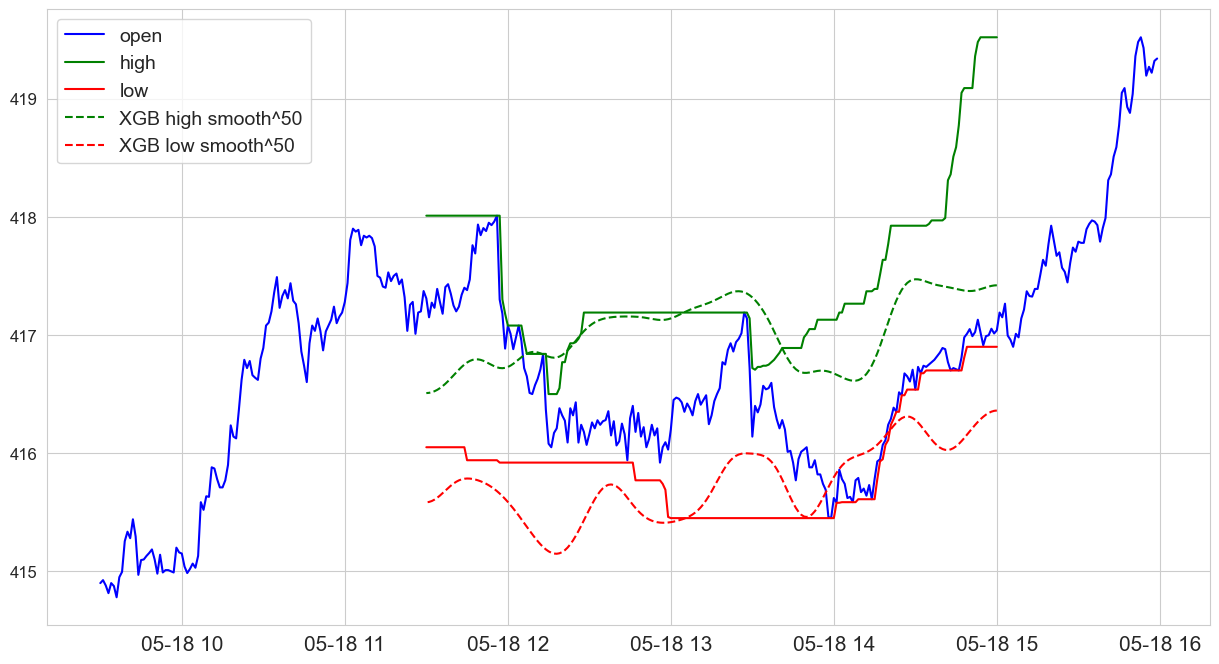

MAE_HIGH_S: 0.5377279418402424
MAE_LOW_S: 0.3644488658862684


In [15]:
#Smooth the XGB predictions
def smooth(array):
    new=np.ndarray((len(array),))
    for i in range(len(array)):
        if i==0:
            new[i]=(array[0]+array[1])/2
        elif i==len(array)-1:
            new[i]=(array[i-1]+array[i])/2
        else:
            new[i]=(array[i-1]+array[i]+array[i+1])/3
    return new

def nsmooth(array,n):
    if n==0: return array
    return nsmooth(smooth(array),n-1)

n=50
smoothpredh=nsmooth(xgbh.predict(X_test),n)
smoothpredl=nsmooth(xgbl.predict(X_test),n)

plt.figure(figsize=(15,8))
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18)) & (dfhl.time<pd.Timestamp(2023,5,19))].open,'b',label='open')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].high,'g',label='high')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].low,'r',label='low')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(smoothpredh),'g--',label=f'XGB high smooth^{n}')
plt.plot(dfhl.loc[(dfhl.time>=pd.Timestamp(2023,5,18,11,30)) & (dfhl.time<=pd.Timestamp(2023,5,18,15))].time,
         np.flip(smoothpredl),'r--',label=f'XGB low smooth^{n}')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

xgb_mae_high_s=mean_absolute_error(smoothpredh,Y_test['High'])
xgb_mae_low_s=mean_absolute_error(smoothpredl,Y_test['Low'])

print('MAE_HIGH_S:',xgb_mae_high_s)
print('MAE_LOW_S:',xgb_mae_low_s)



In [17]:
#Check the MAE on the training set

xgb_mae_high_train=mean_absolute_error(xgbh.predict(X_train),Y_train['High'])
xgb_mae_low_train=mean_absolute_error(xgbl.predict(X_train),Y_train['Low'])
print('MAE_HIGH_T:',xgb_mae_high_train)
print('MAE_LOW_T:',xgb_mae_low_train)

MAE_HIGH_T: 0.3211367161713991
MAE_LOW_T: 0.26735555989362886
